## 1-period, 2-player MARL setting

Changes made
* Env:
  * Changed obs to be `I: [v, p0, sigma_v, sigma_u]` and `MM: [y, p0, sigma_v, sigma_u]`
    * made order consistent (`v, y` at start and distribution params at the end), also changed any code that does e.g. `obs[0]=v` to account for that
    * removed `**2` from the stdevs
  * action scaling as an explicit variable that gets passed to `Env` at init, and into the training & eval functions
* Agents:
  * made 2-hidden-layer by default (was 1-hidden-layer), adjustable number of neurons per hidden layer (`hidden_dim` at init)
  * made Tanh on output optional (specify with `output_tanh=True/False` at init)
  * added `.predict()` method used at eval time: this one either outputs the mean (`deterministic=True`) or samples an action from the dist (`deterministic=False`). At inference (eval) you want to use deterministic actions, i.e. the mean. During training, we're still using `.forward()` as before, which outputs the mean and std (this is convention). 
* Added OptimalAgents
  * purpose: if you want to train vs a fixed agent
  * can be used for training & eval just like a `GaussianPolicy` agent. training functions are adjusted to not try to backprop into these agents (because they don't have any parameters with `require_grad=True`).
* Train functions
  * defined functions for individual and batched training
  * include eval via plotting learned order/price functions at regular intervals  
* Eval functions
  * added my action (order/price function) plotting function
  * made Kristijan's plotting functions consistent: blue dotted is baseline, orange is agent
  * cleaned up Kristijan's profit plotting functions: 
    * now clear about what's being eval'd. E.g. when plotting insider profit, distinguish between simulating `trained I vs trained MM`, `trained I vs optimal MM`, `optimal I vs optimal MM`
    * fixed randomness

## Imports & Definitions

<>:102: SyntaxWarning: invalid escape sequence '\S'
<>:109: SyntaxWarning: invalid escape sequence '\l'
<>:102: SyntaxWarning: invalid escape sequence '\S'
<>:109: SyntaxWarning: invalid escape sequence '\l'
C:\Users\krist\AppData\Local\Temp\ipykernel_3240\2823268962.py:102: SyntaxWarning: invalid escape sequence '\S'
  axs[0, 0].set_title('Market Maker Uncertainty ($\Sigma_n$)')
C:\Users\krist\AppData\Local\Temp\ipykernel_3240\2823268962.py:109: SyntaxWarning: invalid escape sequence '\l'
  axs[0, 1].set_title('Price Impact ($\lambda_n$)')


📈 Kyle Model Equilibrium Results
N = 25, Sigma_0 = 2.0, sigma_u^2 = 1.0

    Period     h_n  Sigma_n  Lambda_n  Beta_n  Alpha_n
0        1  0.9643   1.9286    0.2623  0.1360   1.8380
1        2  0.9629   1.8572    0.2623  0.1412   1.8355
2        3  0.9615   1.7856    0.2623  0.1469   1.8328
3        4  0.9599   1.7140    0.2623  0.1530   1.8298
4        5  0.9581   1.6422    0.2623  0.1597   1.8266
5        6  0.9562   1.5702    0.2622  0.1670   1.8231
6        7  0.9541   1.4982    0.2622  0.1750   1.8193
7        8  0.9518   1.4259    0.2622  0.1839   1.8151
8        9  0.9492   1.3535    0.2622  0.1937   1.8104
9       10  0.9464   1.2809    0.2621  0.2046   1.8053
10      11  0.9432   1.2081    0.2621  0.2169   1.7995
11      12  0.9395   1.1351    0.2620  0.2308   1.7929
12      13  0.9354   1.0617    0.2619  0.2467   1.7855
13      14  0.9306   0.9880    0.2619  0.2650   1.7770
14      15  0.9250   0.9140    0.2617  0.2864   1.7671
15      16  0.9185   0.8395    0.2616  0.3116  

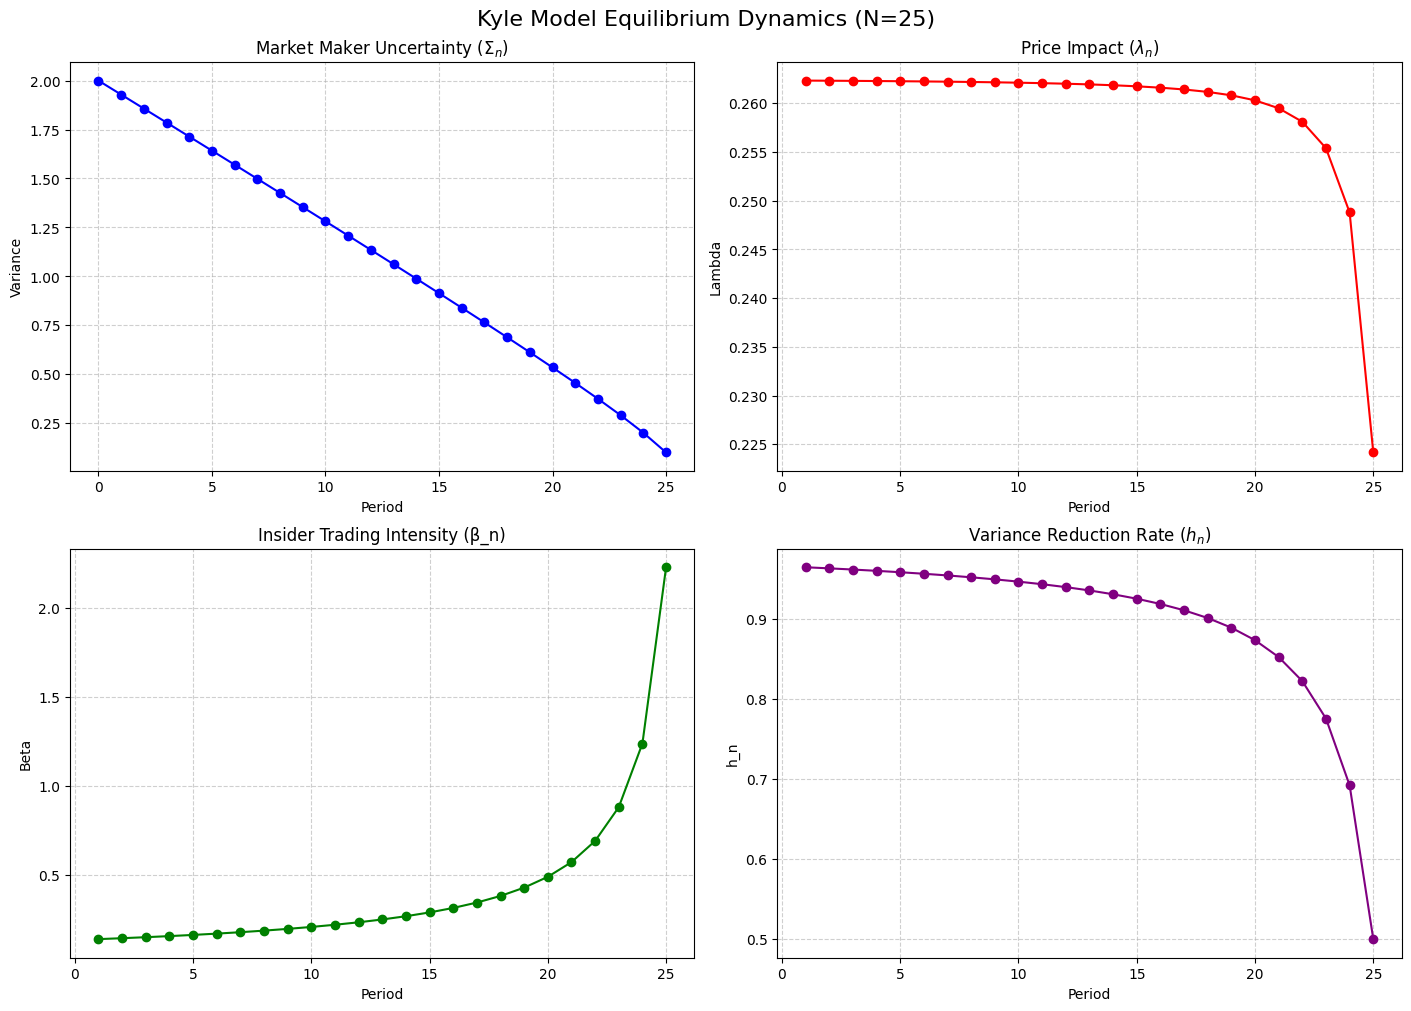

In [57]:
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import pandas as pd

def solve_kyle_model(N: int, sigma2_v: float, sigma2_u: float):
    """
    Calculates the multi-period Kyle model equilibrium using a two-pass algorithm.

    Args:
        N (int): The total number of trading periods.
        sigma2_v (float): The initial variance of the asset's value (Sigma_0).
        sigma2_u (float): The variance of the noise trader's orders.

    Returns:
        dict: A dictionary containing the numpy arrays for each equilibrium
              parameter sequence: 'Sigma', 'Lambda', 'Beta', and 'Alpha'.
    """
    # Helper for readability
    sigma_u = np.sqrt(sigma2_u)

    # --- ⏪ PASS 1: BACKWARD ITERATION for h_n ---
    # h_n = Sigma_n / Sigma_{n-1}
    h = np.zeros(N)
    h[-1] = 0.5  # Terminal condition for the last period (n=N)

    # Iterate backwards from n = N-1 down to n=1
    for n in reversed(range(N - 1)):
        # Calculate theta_{n+1} from the known h_{n+1}
        h_next = h[n + 1]
        theta_next = np.sqrt(h_next / (1 - h_next))

        # Define the function whose root h_n we need to find
        # f(h_n) = theta_{n+1} - (2*h_n - 1) / (h_n * sqrt(1-h_n)) = 0
        def root_func(h_n):
            if h_n <= 0.5 or h_n >= 1.0: # Numerical stability
                return np.inf
            return theta_next - (2 * h_n - 1) / (h_n * np.sqrt(1 - h_n))

        # Find the root h_n in the interval (0.5, 1.0)
        # brentq is a robust and efficient choice here.
        h[n] = brentq(root_func, 0.5 + 1e-9, 1.0 - 1e-9)

    # --- ⏩ PASS 2: FORWARD ITERATION for equilibrium parameters ---
    Sigma = np.zeros(N + 1)
    Lambda = np.zeros(N)
    Beta = np.zeros(N)
    Alpha = np.zeros(N)

    Sigma[0] = sigma2_v # Initial condition

    # Iterate forward from n=1 to N
    for n in range(N):
        # Update variance using the pre-calculated h_n
        Sigma[n + 1] = h[n] * Sigma[n]

        # Calculate the equilibrium parameters for period n
        Lambda[n] = np.sqrt((1 - h[n]) * Sigma[n + 1]) / sigma_u
        Beta[n] = (np.sqrt(1 - h[n]) * sigma_u) / np.sqrt(Sigma[n + 1])
        Alpha[n] = (sigma_u / (2 * np.sqrt(Sigma[n]))) * np.sqrt(h[n] / (1 - h[n]))
    
    return {
        "Sigma": Sigma,
        "Lambda": Lambda,
        "Beta": Beta,
        "Alpha": Alpha,
        "h": h
    }

if __name__ == '__main__':
    # --- Model Parameters ---
    N_periods = 25
    asset_value_variance = 2.0
    noise_trade_variance = 1.0

    # --- Solve the Model ---
    equilibrium = solve_kyle_model(N_periods, asset_value_variance, noise_trade_variance)

    # --- Display Results ---
    print("📈 Kyle Model Equilibrium Results")
    print(f"N = {N_periods}, Sigma_0 = {asset_value_variance}, sigma_u^2 = {noise_trade_variance}\n")

    # Create a pandas DataFrame for a clean table view
    periods = np.arange(1, N_periods + 1)
    df = pd.DataFrame({
        'Period': periods,
        'h_n': equilibrium['h'],
        'Sigma_n': equilibrium['Sigma'][1:],
        'Lambda_n': equilibrium['Lambda'],
        'Beta_n': equilibrium['Beta'],
        'Alpha_n': equilibrium['Alpha']
    })
    pd.set_option('display.precision', 4)
    print(df)

    # --- Plotting Key Dynamics ---
    fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
    fig.suptitle(f'Kyle Model Equilibrium Dynamics (N={N_periods})', fontsize=16)

    # 1. Uncertainty (Sigma_n)
    axs[0, 0].plot(np.arange(N_periods + 1), equilibrium['Sigma'], 'o-', color='b')
    axs[0, 0].set_title('Market Maker Uncertainty ($\Sigma_n$)')
    axs[0, 0].set_xlabel('Period')
    axs[0, 0].set_ylabel('Variance')
    axs[0, 0].grid(True, linestyle='--', alpha=0.6)

    # 2. Price Impact (Lambda_n)
    axs[0, 1].plot(periods, equilibrium['Lambda'], 'o-', color='r')
    axs[0, 1].set_title('Price Impact ($\lambda_n$)')
    axs[0, 1].set_xlabel('Period')
    axs[0, 1].set_ylabel('Lambda')
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)

    # 3. Trading Intensity (Beta_n)
    axs[1, 0].plot(periods, equilibrium['Beta'], 'o-', color='g')
    axs[1, 0].set_title('Insider Trading Intensity (β_n)')
    axs[1, 0].set_xlabel('Period')
    axs[1, 0].set_ylabel('Beta')
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)

    # 4. Variance Reduction Rate (h_n)
    axs[1, 1].plot(periods, equilibrium['h'], 'o-', color='purple')
    axs[1, 1].set_title('Variance Reduction Rate ($h_n$)')
    axs[1, 1].set_xlabel('Period')
    axs[1, 1].set_ylabel('h_n')
    axs[1, 1].grid(True, linestyle='--', alpha=0.6)

    plt.show()

In [1]:
import numpy as np
import functools
from pettingzoo import AECEnv
from gymnasium import spaces
from pettingzoo.utils.agent_selector import agent_selector
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd

### Eval function definitions

Equilibrium parameters and actions:

In [42]:
def equilibrium_insider_action(v, mean_v, beta):
    return beta * (v - mean_v)

def equilibrium_market_maker_action(y, mean_v, lambda_):
    return mean_v + lambda_ * y

### Env & Agent definitions

In [ ]:
class KyleOnePeriodAEC(AECEnv):
    metadata = {
        "render_modes": ["human"],
        "name": "KyleOnePeriodAEC",
    }

    def __init__(self, sigma_v=2.0, sigma_u=1.0, p0=0.5, gamma=0.9, action_scaling=5, T=1):
        super().__init__()
        self.sigma_v_initial = sigma_v
        self.sigma_u_initial = sigma_u
        self.p0_initial = p0
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.p0 = p0
        self.timestep = 0
        self.gamma = gamma
        self.T = T
        self.beta = np.zeros(self.T)
        self.lmbd = np.zeros(self.T)
        self.alpha = np.zeros(self.T)
        self.delta = np.zeros(self.T)
        self.Sigma = np.zeros(self.T)


        self.possible_agents = ["insider", "market_maker"]
        self.agents = self.possible_agents[:]
        self.render_mode = None
        self.rewards = {a: 0 for a in self.agents}
        self.agent_selector = agent_selector(self.agents)

        self.action_spaces = {
            "insider": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32),
            "market_maker": spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        }

        self.observation_spaces = {
            "insider": spaces.Box(low=-10, high=10, shape=(5,), dtype=np.float32),
            "market_maker": spaces.Box(low=-10, high=10, shape=(5,), dtype=np.float32),
        }
        self.action_scaling = action_scaling

    def reset(self, seed=None, options=None):
        self.agents = self.possible_agents[:]
        self.rewards = {a: 0 for a in self.agents}
        self._cumulative_rewards = {a: 0 for a in self.agents}
        self.terminations = {a: False for a in self.agents}
        self.truncations = {a: False for a in self.agents}
        self.infos = {a: {} for a in self.agents}
        self.timestep = 0
        self.sigma_v = self.sigma_v_initial
        self.sigma_u = self.sigma_u_initial
        self.p0 = self.p0_initial
        self.optimal_x = 0
        self.optimal_y = 0
        self.beta = np.zeros(self.T)
        self.lmbd = np.zeros(self.T)
        self.alpha = np.zeros(self.T)
        self.delta = np.zeros(self.T)
        self.Sigma = np.zeros(self.T)

        # Sample true value
        self.v = torch.normal(self.p0, self.sigma_v, size=(1,)).item()
        self.u = torch.normal(0, self.sigma_u, size=(1,)).item()
        self.p = 0
        self.y = 0

        # Set first agent
        self.agent_selector.reinit(self.agents)
        self.agent_selection = self.agent_selector.next()

    def solve_kyle_model(self):
        """
        Calculates the multi-period Kyle model equilibrium using a two-pass algorithm.

        Args:
            N (int): The total number of trading periods.
            sigma2_v (float): The initial variance of the asset's value (Sigma_0).
            sigma2_u (float): The variance of the noise trader's orders.

        Returns:
            dict: A dictionary containing the numpy arrays for each equilibrium
                parameter sequence: 'Sigma', 'Lambda', 'Beta', and 'Alpha'.
        """
        # Helper for readability
        sigma_u = np.sqrt(self.sigma_u)

        # --- ⏪ PASS 1: BACKWARD ITERATION for h_n ---
        # h_n = Sigma_n / Sigma_{n-1}
        h = np.zeros(self.T)
        h[-1] = 0.5  # Terminal condition for the last period (n=N)

        # Iterate backwards from n = N-1 down to n=1
        for n in reversed(range(self.T - 1)):
            # Calculate theta_{n+1} from the known h_{n+1}
            h_next = h[n + 1]
            theta_next = np.sqrt(h_next / (1 - h_next))

            # Define the function whose root h_n we need to find
            # f(h_n) = theta_{n+1} - (2*h_n - 1) / (h_n * sqrt(1-h_n)) = 0
            def root_func(h_n):
                if h_n <= 0.5 or h_n >= 1.0: # Numerical stability
                    return np.inf
                return theta_next - (2 * h_n - 1) / (h_n * np.sqrt(1 - h_n))

            # Find the root h_n in the interval (0.5, 1.0)
            # brentq is a robust and efficient choice here.
            h[n] = brentq(root_func, 0.5 + 1e-9, 1.0 - 1e-9)

        # --- ⏩ PASS 2: FORWARD ITERATION for equilibrium parameters ---
        Sigma = np.zeros(self.T + 1)
        Lambda = np.zeros(self.T)
        Beta = np.zeros(self.T)
        Alpha = np.zeros(self.T)

        Sigma[0] = self.sigma_v_initial # Initial condition

        # Iterate forward from n=1 to N
        for n in range(self.T):
            # Update variance using the pre-calculated h_n
            Sigma[n + 1] = h[n] * Sigma[n]

            # Calculate the equilibrium parameters for period n
            Lambda[n] = np.sqrt((1 - h[n]) * Sigma[n + 1]) / sigma_u
            Beta[n] = (np.sqrt(1 - h[n]) * sigma_u) / np.sqrt(Sigma[n + 1])
            Alpha[n] = (sigma_u / (2 * np.sqrt(Sigma[n]))) * np.sqrt(h[n] / (1 - h[n]))
        
        self.beta = Beta
        self.lmbd = Lambda
        self.alpha = Alpha
        self.h = h
        self.Sigma = Sigma

        self.delta[self.T-1] = 0  # Terminal condition
        
        for n in reversed(range(1, self.T-1)):
            self.delta[n-1] = self.delta[n] + self.alpha[n] * ( self.lmbd[n] ** 2 ) * self.sigma_u


    def observe_insider(self):
        return torch.tensor([self.v, self.p0, self.sigma_v, self.beta[self.timestep]], dtype=torch.float32)

    def observe_market_maker(self):
        return torch.tensor([self.y, self.p0, self.sigma_v, self.lmbd[self.timestep]], dtype=torch.float32)

    def observe(self, agent):
        if agent == "insider":
            return self.observe_insider()
        elif agent == "market_maker":
            return self.observe_market_maker()

    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]

    def step(self, action):
        if self.terminations[self.agent_selection] or self.truncations[self.agent_selection]:
            return self._was_dead_step(action)

        agent = self.agent_selection

        # Store the action
        if agent == "insider":


            self.insider_action = action[0] * self.action_scaling
            self.u = torch.normal(0, self.sigma_u, size=(1,)).item()
            self.y = self.insider_action + self.u

        elif agent == "market_maker":
            self.market_maker_action = action[0] * self.action_scaling


            insider_profit = (self.v - self.market_maker_action) * self.insider_action 
            market_maker_loss = - (self.market_maker_action - self.v) ** 2

            # Assign rewards
            self.rewards = {
                "insider": insider_profit,
                "market_maker": market_maker_loss
            }

            self.p0 = equilibrium_market_maker_action(self.y, self.p0, self.lmbd[self.timestep])

            # Update timestep
            self.timestep += 1
            if self.timestep >= self.T:
                self.terminations = {a: True for a in self.agents}

            # Update cumulative rewards
            for a in self.agents:
                self._cumulative_rewards[a] += self.rewards[a]

        # Get next agent
        self.agent_selection = self.agent_selector.next()

    def render(self):
        print(f"Step: {self.timestep}")
        print(f"True value v: {self.v:.2f}")
        print(f"Order flow y: {self.y:.2f}")
        if hasattr(self, 'rewards'):
            print(f"Agents' rewards: {self._cumulative_rewards}")

    def close(self):
        pass

Policy / Actor definition. 

*Note: this is a 2-hidden-layer arch (default for PPO), can use either ReLU or Tanh activations. For [-1,1] actions people often use Tanh. Experiment with what works better.*

In [ ]:
class GaussianActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64, activation_fn=nn.Tanh, output_tanh=False):
        super().__init__()
        # self.fc = nn.Sequential(
        #     nn.Linear(obs_dim, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, act_dim)
        # )
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn()
        )
        self.mean = nn.Linear(hidden_dim, act_dim)  # this is what we get actions from
        self.log_std = nn.Parameter(torch.ones(act_dim) * - 2, requires_grad=True)
        self.output_tanh = output_tanh

    def forward(self, x):
        x = self.net(x)
        if self.output_tanh:
            mean = torch.tanh(self.mean(x))
        else:
            mean = self.mean(x)  
        # std = torch.exp(self.log_std)
        std = self.log_std.exp().expand_as(mean)
        return mean, std

    def predict(self, x, deterministic=False):
        with torch.no_grad():
            mean, std = self.forward(x)  # equivalent to self(x)
            if deterministic:
                action = mean
            else:
                action = torch.normal(mean, std)
            action = action.detach().numpy()
            if len(x.shape) == 1:  # single observation, would otherwise be returned as array(action), want just the action
                action = action[0]
        return action

In [109]:
class OptimalInsider(nn.Module):
    def __init__(self, p0, beta, action_scaling):
        super().__init__()
        self.dummy_param = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.p0 = p0
        self.beta = beta
        self.action_scaling = action_scaling  # need b/c any action sampled from this will be scaled by the factor

    # def parameters(self):
    #     return iter([self.dummy_param])

    def forward(self, x):
        v = float(x[0])
        mean_action = equilibrium_insider_action(v, self.p0, self.beta) / self.action_scaling
        mean = torch.tensor([mean_action], requires_grad=False)
        std = torch.tensor(1e-10, requires_grad=False).expand_as(mean)
        return mean, std
    
    def predict(self, x, deterministic=True):
        mean, std = self.forward(x)
        if deterministic:
            return mean
        else:
            return torch.normal(mean, std)
    
class OptimalMarketMaker(nn.Module):
    def __init__(self, p0, sigma_v, sigma_u, action_scaling):
        super().__init__()
        self.dummy_param = torch.nn.Parameter(torch.zeros(1), requires_grad=False)
        self.p0 = p0
        self.sigma_v = sigma_v
        self.sigma_u = sigma_u
        self.action_scaling = action_scaling

    # def parameters(self):
    #     return iter([self.dummy_param])

    def forward(self, x):
        y = float(x[0])
        mean_action = equilibrium_insider_action(y, self.p0, self.sigma_v, self.sigma_u) / self.action_scaling
        mean = torch.tensor([mean_action], requires_grad=False)
        std = torch.tensor(1e-10, requires_grad=False).expand_as(mean)
        return mean, std
    
    def predict(self, x, deterministic=True):
        mean, std = self.forward(x)
        if deterministic:
            return mean
        else:
            return torch.normal(mean, std)
    

In [110]:
class Critic(nn.Module):
    def __init__(self, obs_dim, hidden_dim=64, activation_fn=nn.Tanh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, 1)  # Output: V(s)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)  # Return scalar value per observation


### Tests for env & agents

Test defining env & agents, and stepping env with deterministic `predict()` actions (what happens during eval)

In [111]:
# test env definition etc
env = KyleOnePeriodAEC(T=20, sigma_v=1)  # play 3 periods to test multiple steps
env.reset()

# reset
observations = env.reset()
done = False

# define dummy agents
activation_fn = nn.ReLU

policies = {
    "insider": GaussianActor(obs_dim=5, act_dim=1, hidden_dim=64, activation_fn=activation_fn),
    "market_maker": GaussianActor(obs_dim=5, act_dim=1, hidden_dim=64, activation_fn=activation_fn)
}

# test stepping env until it terminates (with predict())
print("=== stepping with .predict(), simulating eval (deterministic) ===")
while not done:  # stops automatically when all agents are done

    
    agent = env.agent_selection
    obs = env.observe(agent)

    action = policies[agent].predict(obs, deterministic=True) if not env.terminations[agent] else None
    action = torch.tensor([action], dtype=torch.float32)


    env.step(action)
    print("environment step: ", env.timestep)
    env.render()

        
    if env.timestep >= env.T:
        done = True
        print("--all agents done after this one--")



=== stepping with .predict(), simulating eval (deterministic) ===
environment step:  0
Step: 0
True value v: 1.02
Order flow y: 2.00
Agents' rewards: {'insider': 0, 'market_maker': 0}
environment step:  1
Step: 1
True value v: 1.02
Order flow y: 2.00
Agents' rewards: {'insider': tensor(-0.0055), 'market_maker': tensor(-0.0003)}
environment step:  1
Step: 1
True value v: 1.02
Order flow y: -0.03
Agents' rewards: {'insider': tensor(-0.0055), 'market_maker': tensor(-0.0003)}
environment step:  2
Step: 2
True value v: 1.02
Order flow y: -0.03
Agents' rewards: {'insider': tensor(0.0966), 'market_maker': tensor(-0.1209)}
environment step:  2
Step: 2
True value v: 1.02
Order flow y: 0.68
Agents' rewards: {'insider': tensor(0.0966), 'market_maker': tensor(-0.1209)}
environment step:  3
Step: 3
True value v: 1.02
Order flow y: 0.68
Agents' rewards: {'insider': tensor(0.1756), 'market_maker': tensor(-0.1931)}
environment step:  3
Step: 3
True value v: 1.02
Order flow y: 0.94
Agents' rewards: {'i

Function that evals and plots the learned functions, so:
* insider: plot `order(value)`, $I(v) = x$
* market maker: plot `price(order_I + order_noise)`, $MM(y) = p$

dummy optimal insiders and market makers to train against (can drop these in the policies training loop)

In [112]:
def solve_kyle_model_mine(N: int, sigma2_v: float, sigma2_u: float):
    """
    Calculates the multi-period Kyle model equilibrium using a two-pass algorithm.

    Args:
        N (int): The total number of trading periods.
        sigma2_v (float): The initial variance of the asset's value (Sigma_0).
        sigma2_u (float): The variance of the noise trader's orders.

    Returns:
        dict: A dictionary containing the numpy arrays for each equilibrium
              parameter sequence: 'Sigma', 'Lambda', 'Beta', and 'Alpha'.
    """
    # Helper for readability
    sigma_u = np.sqrt(sigma2_u)

    # --- ⏪ PASS 1: BACKWARD ITERATION for h_n ---
    # h_n = Sigma_n / Sigma_{n-1}
    h = np.zeros(N)
    h[-1] = 0.5  # Terminal condition for the last period (n=N)

    # Iterate backwards from n = N-1 down to n=1
    for n in reversed(range(N - 1)):
        # Calculate theta_{n+1} from the known h_{n+1}
        h_next = h[n + 1]
        theta_next = np.sqrt(h_next / (1 - h_next))

        # Define the function whose root h_n we need to find
        # f(h_n) = theta_{n+1} - (2*h_n - 1) / (h_n * sqrt(1-h_n)) = 0
        def root_func(h_n):
            if h_n <= 0.5 or h_n >= 1.0: # Numerical stability
                return np.inf
            return theta_next - (2 * h_n - 1) / (h_n * np.sqrt(1 - h_n))

        # Find the root h_n in the interval (0.5, 1.0)
        # brentq is a robust and efficient choice here.
        h[n] = brentq(root_func, 0.5 + 1e-9, 1.0 - 1e-9)

    # --- ⏩ PASS 2: FORWARD ITERATION for equilibrium parameters ---
    Sigma = np.zeros(N + 1)
    Lambda = np.zeros(N)
    Beta = np.zeros(N)
    Alpha = np.zeros(N)

    Sigma[0] = sigma2_v # Initial condition

    # Iterate forward from n=1 to N
    for n in range(N):
        # Update variance using the pre-calculated h_n
        Sigma[n + 1] = h[n] * Sigma[n]

        # Calculate the equilibrium parameters for period n
        Lambda[n] = np.sqrt((1 - h[n]) * Sigma[n + 1]) / sigma_u
        Beta[n] = (np.sqrt(1 - h[n]) * sigma_u) / np.sqrt(Sigma[n + 1])
        Alpha[n] = (sigma_u / (2 * np.sqrt(Sigma[n]))) * np.sqrt(h[n] / (1 - h[n]))
    
    return Beta, Lambda

In [143]:
loss = []

In [144]:
def evaluate_agent_actions_multiperiod(models, env, n_stdevs, action_scaling=5):
    env.reset()
    env.solve_kyle_model()
    I = models["insider"]
    MM = models["market_maker"]

    steps = env.T
    optimal_insider_actions = np.zeros((steps))
    optimal_market_maker_actions = np.zeros((steps))

    trained_insider_actions = np.zeros((steps))
    trained_market_maker_actions = np.zeros((steps))

    values = np.linspace(1, steps, steps)
    beta, lmbd = solve_kyle_model_mine(steps, env.sigma_v_initial, env.sigma_u_initial)

    p0 = env.p0

        

    for i in range(len(values)):
        
        obs_I = env.observe_insider()
        trained_insider_actions[i] = I.predict(obs_I, deterministic=True) * action_scaling
        optimal_insider_actions[i] = equilibrium_insider_action(env.v, p0, beta[i])
        env.step(torch.tensor([trained_insider_actions[i] / action_scaling] , dtype=torch.float32))
        u = env.u
        y = optimal_insider_actions[i] + u
        

        obs_MM = env.observe_market_maker()
        trained_market_maker_actions[i] = MM.predict(obs_MM, deterministic=True) * action_scaling
        optimal_market_maker_actions[i] = equilibrium_market_maker_action(y, p0, lmbd[i])
        env.step(torch.tensor([trained_market_maker_actions[i] / action_scaling] , dtype=torch.float32)) 
        p0 = lmbd[i] * y + p0
        loss.append(env.rewards["insider"])
        

    env.reset()

    # plot: 2 subplots. one for insider (values vs action) and one for market maker (order vs action)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # Insider subplot
    ax1.plot(values, optimal_insider_actions, label="Optimal", linestyle='--')
    ax1.plot(values, trained_insider_actions, label="Trained", linestyle='-')
    ax1.axvline(x=env.p0, color='black', linestyle=':', alpha=0.5)
    ax1.axhline(y=0, color='black', linestyle=':', alpha=0.5)
    ax1.set_title("Insider Action")
    ax1.set_xlabel("Timestep t")
    ax1.set_ylabel("Action x")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Market Maker subplot
    ax2.plot(values, optimal_market_maker_actions, label="Optimal", linestyle='--')
    ax2.plot(values, trained_market_maker_actions, label="Trained", linestyle='-')
    ax2.axvline(x=0, color='black', linestyle=':', alpha=0.5)
    ax2.axhline(y=env.p0, color='black', linestyle=':', alpha=0.5)
    ax2.set_title("Market Maker Action")
    ax2.set_xlabel("Timestep t")
    ax2.set_ylabel("Price p")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show() 


### Train function definitions
* individual: rollout 1 episode, update agents, repeat for `num_episodes` steps
* batched: rollout `batch_size` episodes, update agents (on mean batch rewards, normalized), repeat for `num_iterations` steps
  * --> total of `num_iterations * batch_size` episodes rolled out

Need to experiment which is better! To me it seems individual is winning?

In [121]:
def compute_returns(rewards, gamma=1.0):
    returns = []
    G = 0
    if len(rewards) > 1:
        # Normalize returns in REINFORCE
        returns1 = torch.tensor(rewards)
        returns1 = (returns1 - returns1.mean()) / (returns1.std() + 1e-8)
    
    rewards = returns1.numpy() if len(rewards) > 1 else rewards
    rewards = rewards.tolist() if isinstance(rewards, np.ndarray) else rewards

    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    return returns

In [122]:
loss_debug = []

In [138]:
def train_both_reinforce_individual(policies, optimizers, env, num_episodes=10000, plot_every=None, action_scaling=5):
    """trains both agents using REINFORCE, via `rollout 1 episode, update agents, repeat`
    """
    if plot_every is None:
        plot_every = num_episodes // 10
    
    for episode in range(num_episodes):
        # Reset environment
        env.reset()
        env.solve_kyle_model()

        done = False
        log_probs = {a: [] for a in env.possible_agents}
        rewards = {a: [] for a in env.possible_agents}

        # rollout 1 episode
        while not done:  # while there are still live agents

            agent = env.agent_selection  # whose turn is it?

            obs_I = env.observe(agent)

            # get action via forward() & sampling
            mu, std = policies[agent](obs_I)
            
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum()

            env.step(action.detach().numpy())  # step only this agent!
            
            # record log_prob for update
            log_probs[agent].append(log_prob)

            if agent == "market_maker":
                for agent in env.agents:
                    rewards[agent].append(env.rewards[agent])
            
            if env.timestep >= env.T:
                done = True
                
        # --- Compute returns ---
        for agent in env.agents:
            rewards[agent] = compute_returns(rewards[agent], env.gamma)
            rewards[agent] = torch.tensor(rewards[agent], dtype=torch.float32)

        # --- Policy Gradient Update (REINFORCE) ---
        for agent in env.possible_agents:
            # if agent is optimal, skip training attempt
            if not any(p.requires_grad for p in policies[agent].parameters()):
                continue
            
            if len(rewards[agent]) == 0:
                continue
            
            loss = -torch.sum(torch.stack([
                log_prob * G_t for log_prob, G_t in zip(log_probs[agent], rewards[agent])
            ]))
            loss_debug.append(loss.item())
            optimizers[agent].zero_grad()
            loss.backward()
            optimizers[agent].step()

        # Eval loop

        if (episode+1) % plot_every == 0:
            print(f"Episode: {episode+1}")
            evaluate_agent_actions_multiperiod(policies, env, 2, action_scaling)
    return policies, optimizers

## Training
Set up env, agents, optimizers.

**Note:** for action scaling, can either specify scale factor at env definition (default is 5 like before)
```
env = KyleOnePeriodAEC(action_scaling=action_scale_factor)
```

or via creating the env without scaling, and wrapping it with supersuit
```
env = KyleOnePeriodAEC(action_scaling=1)
env = scale_actions_v0(env_unscaled, scale=action_scale_factor)
```


In [149]:
#### PARAMS ####
action_scale_factor = 5  # defaults to 5 in env & training function definitions
activation_fn = nn.ReLU  # activations for hidden layers. or nn.Tanh (experiment what's better)
output_tanh = False  # if True, puts output through nn.Tanh to ensure [-1,1] (experiment)
hidden_dim = 32
################

env = KyleOnePeriodAEC(action_scaling=action_scale_factor, T=25) 
env.reset()

I_obs_dim = env.observation_spaces["insider"].shape[0]
I_act_dim = env.action_spaces["insider"].shape[0]
MM_obs_dim = env.observation_spaces["market_maker"].shape[0]
MM_act_dim = env.action_spaces["market_maker"].shape[0]
policies = {
    "insider": GaussianActor(obs_dim=I_obs_dim, act_dim=I_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh),
    "market_maker": GaussianActor(obs_dim=MM_obs_dim, act_dim=MM_act_dim, hidden_dim=hidden_dim, activation_fn=activation_fn, output_tanh=output_tanh)
}
optimizers = {a: optim.Adam(policies[a].parameters(), lr=1e-4) for a in policies}

Observe (after 20k episodes of single training)) 
* activations Tanh, output Tanh: action function too tanh-shaped to converge
* activations Tanh, output raw: not quite as much, but still
* activations ReLU, output Tanh: decent convergence
* activations ReLU, output raw: seems very similar tbh

### Training via "1 rollout, 1 update, repeat".
* `plot_every` means 'every X iterations, do a round of eval/plotting'. If you leave it as None it'll do it 10 times over the course of the run

*Note: unless you reinitialize policies & optimizers, this will continue training existing policies when cell is executed again*

Episode: 1000


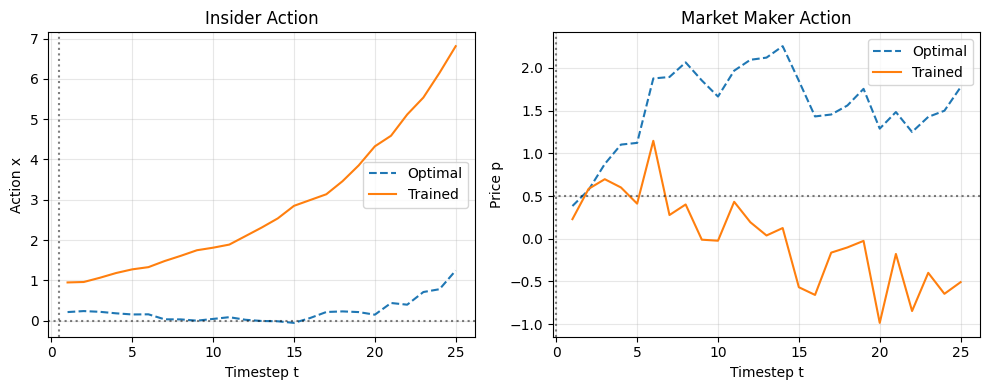

Episode: 2000


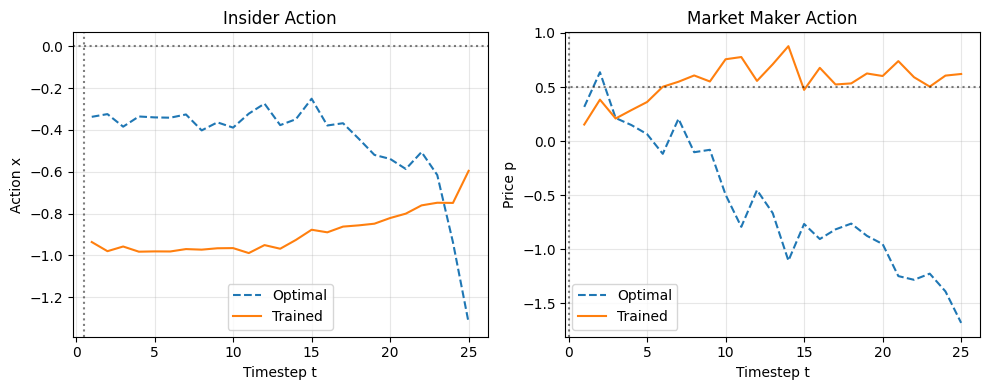

Episode: 3000


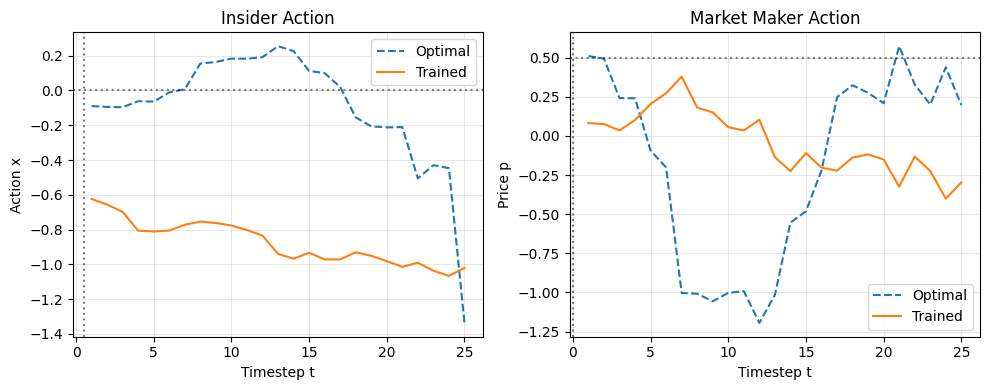

Episode: 4000


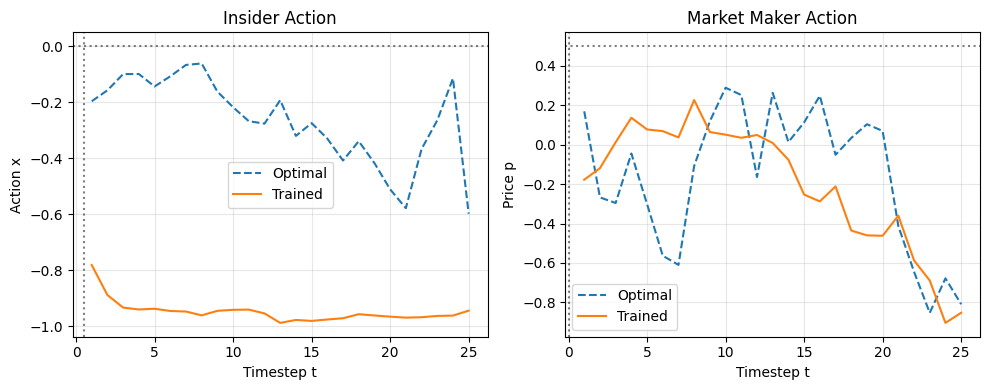

Episode: 5000


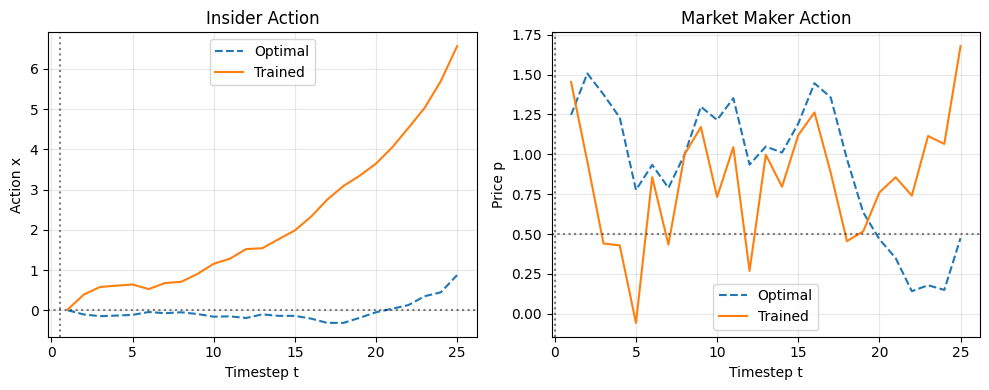

Episode: 6000


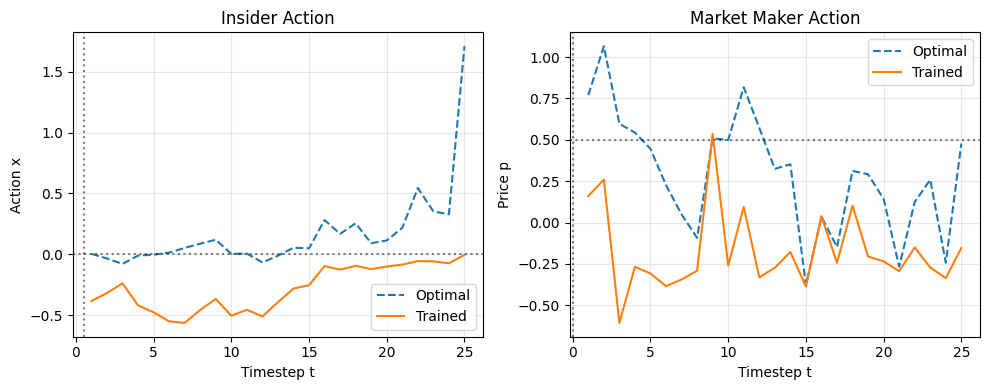

Episode: 7000


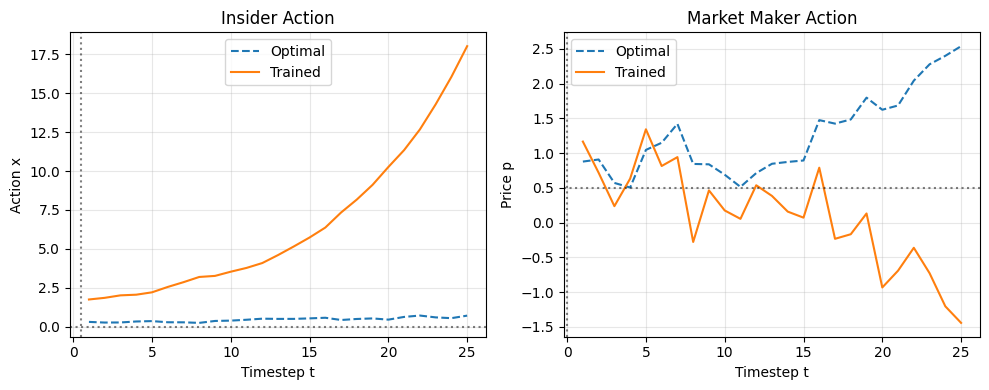

Episode: 8000


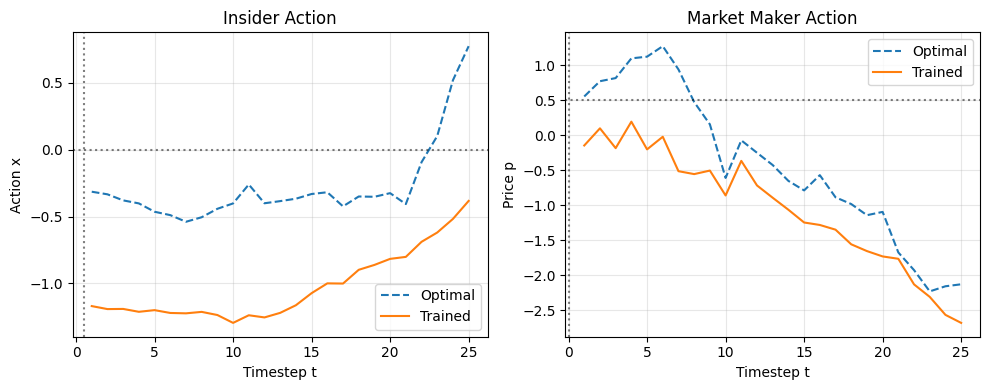

Episode: 9000


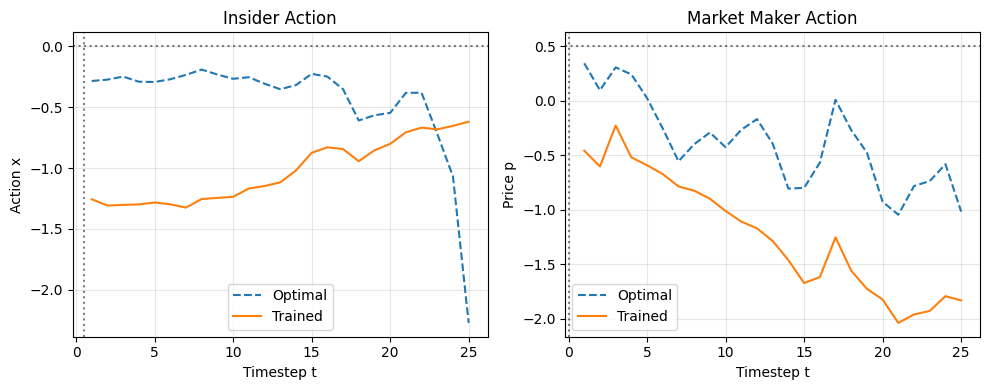

Episode: 10000


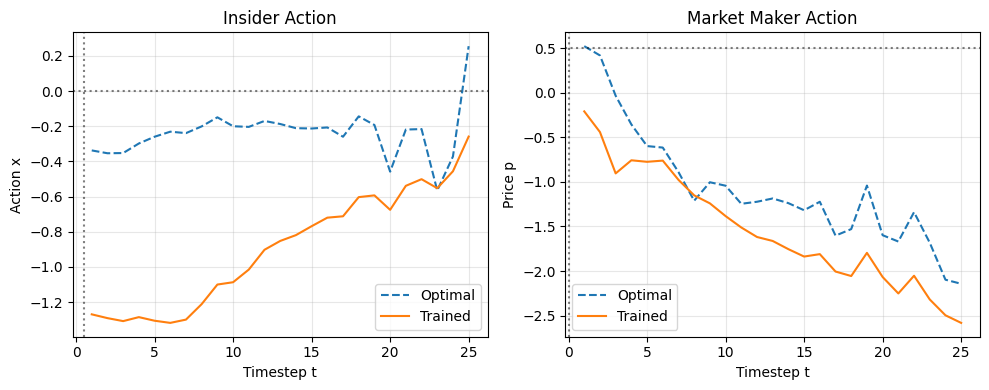

Episode: 11000


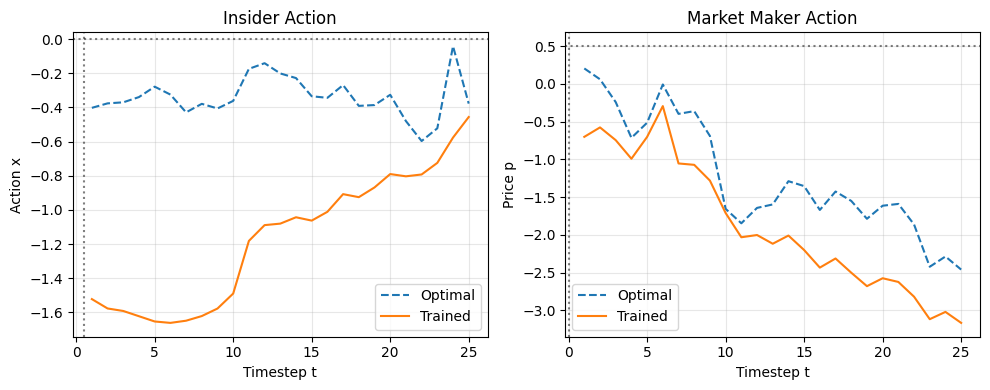

Episode: 12000


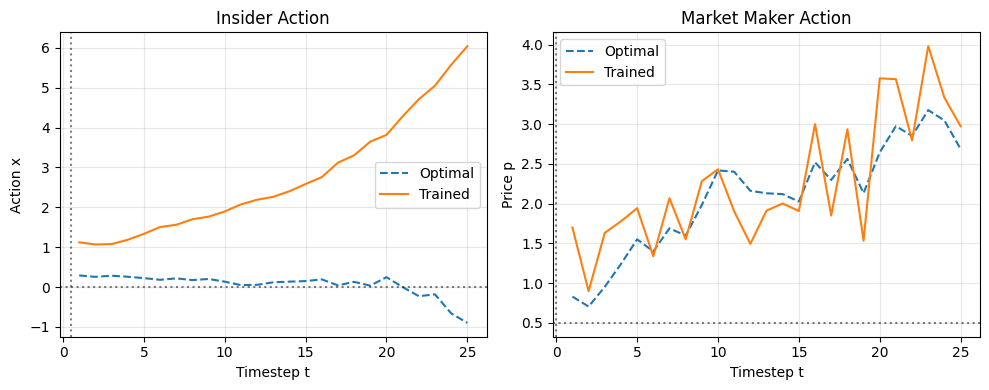

Episode: 13000


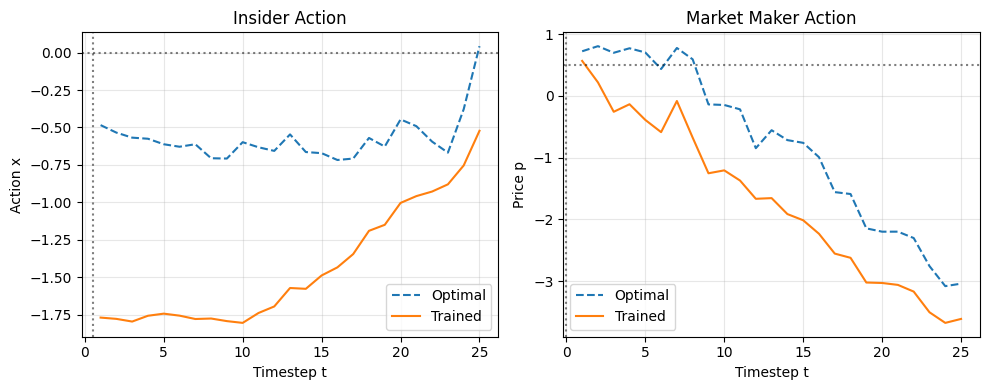

Episode: 14000


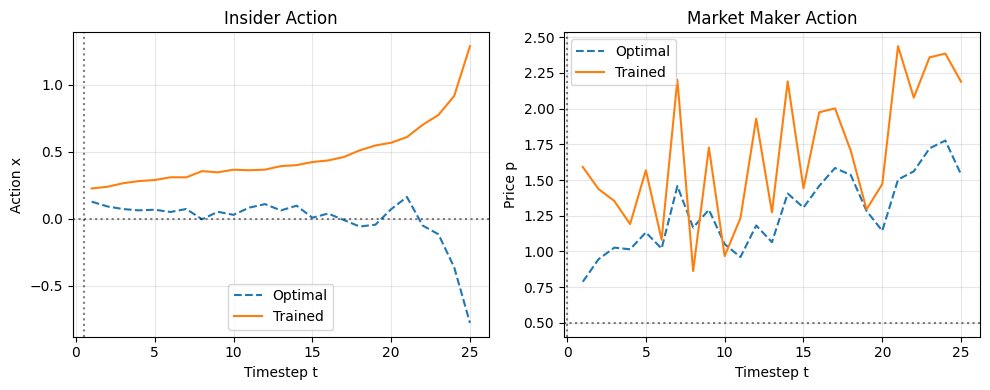

Episode: 15000


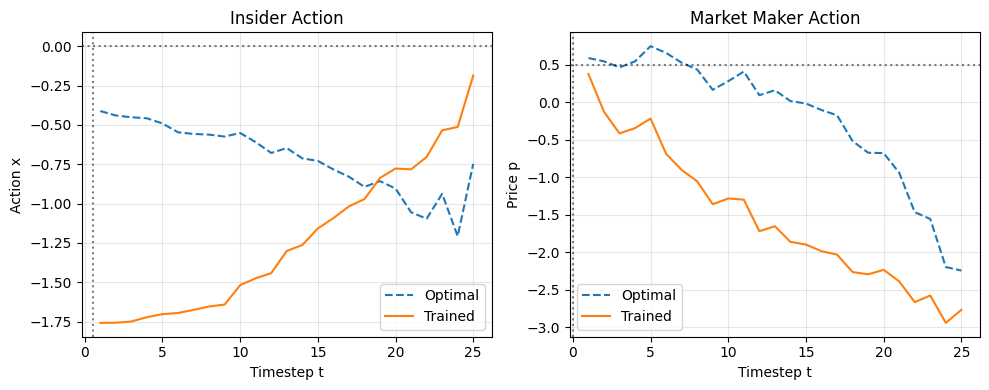

Episode: 16000


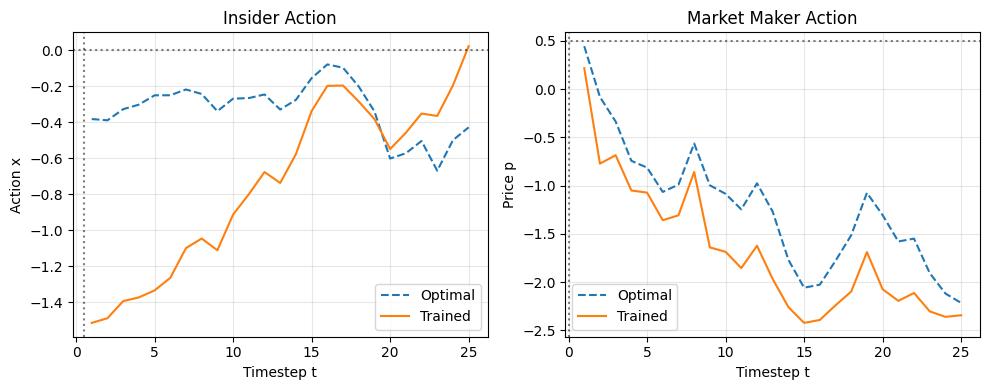

Episode: 17000


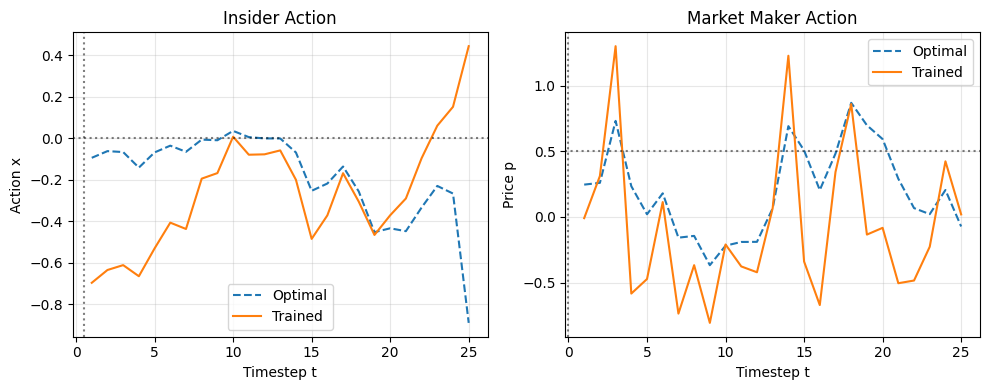

Episode: 18000


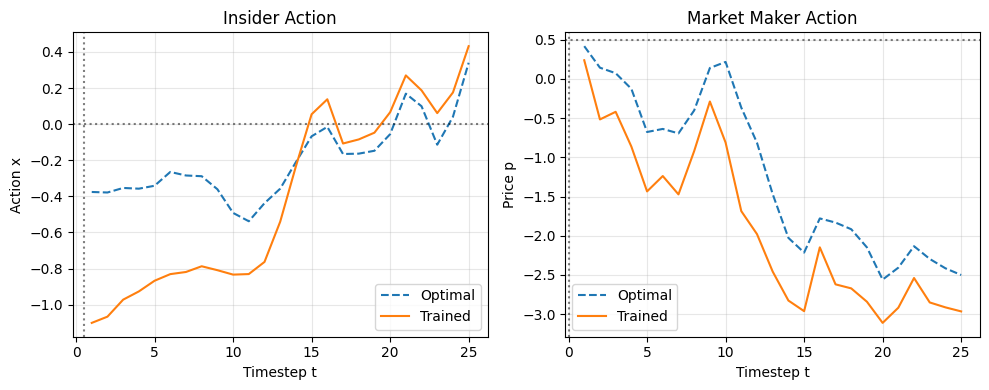

Episode: 19000


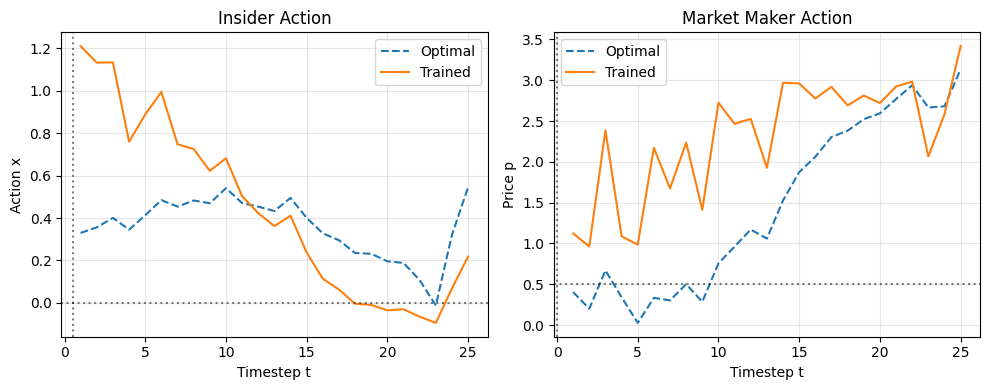

Episode: 20000


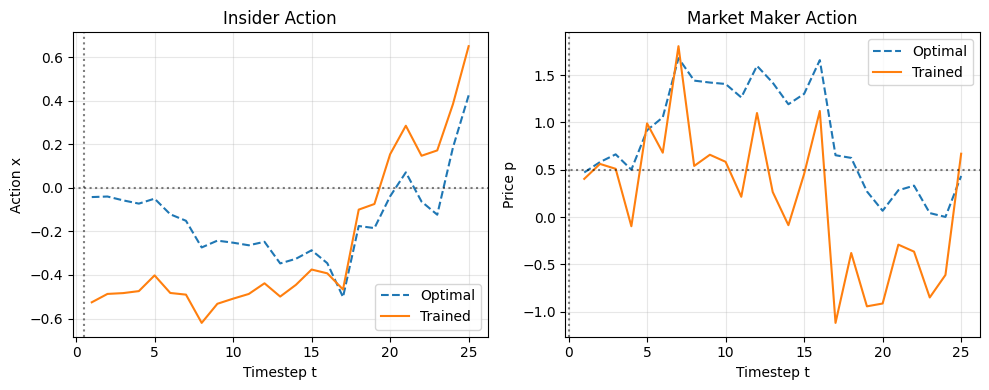

Episode: 21000


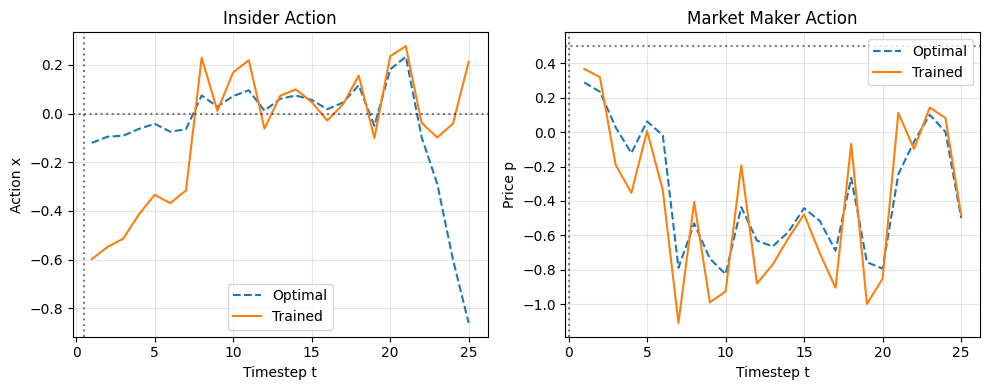

Episode: 22000


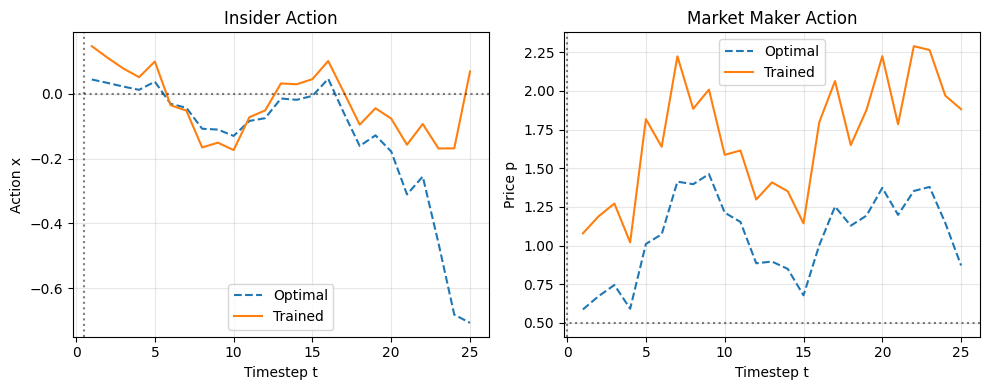

Episode: 23000


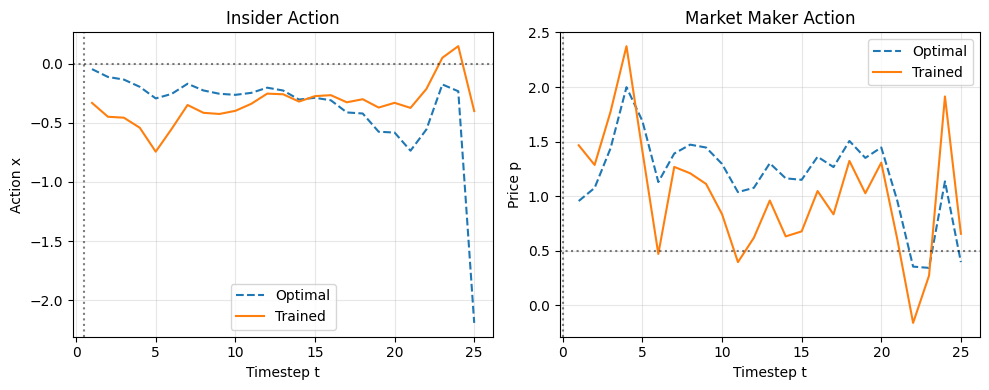

Episode: 24000


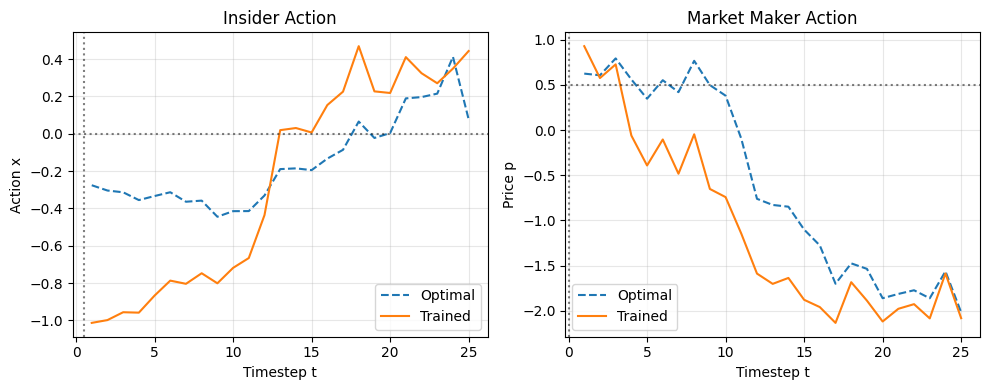

Episode: 25000


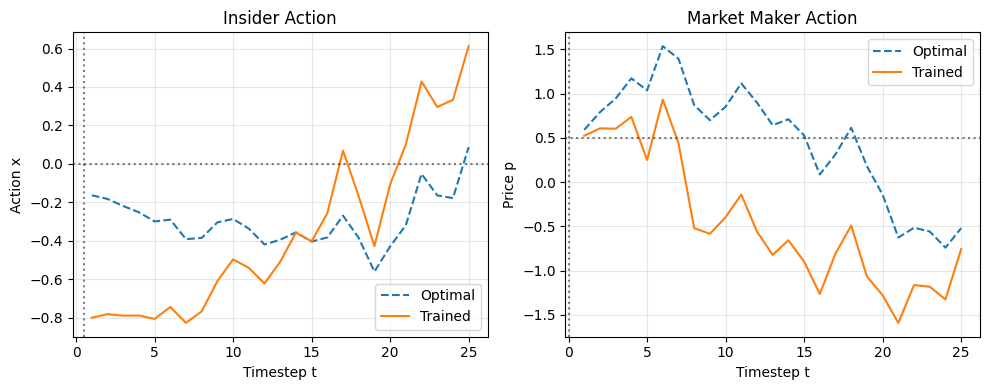

Episode: 26000


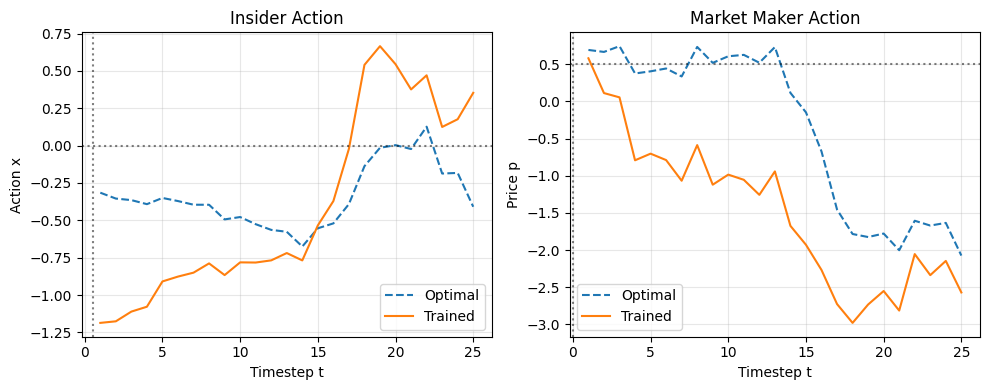

Episode: 27000


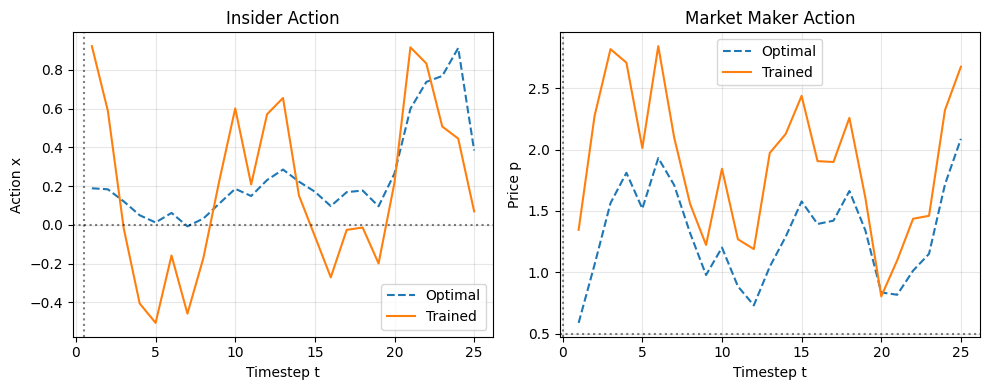

Episode: 28000


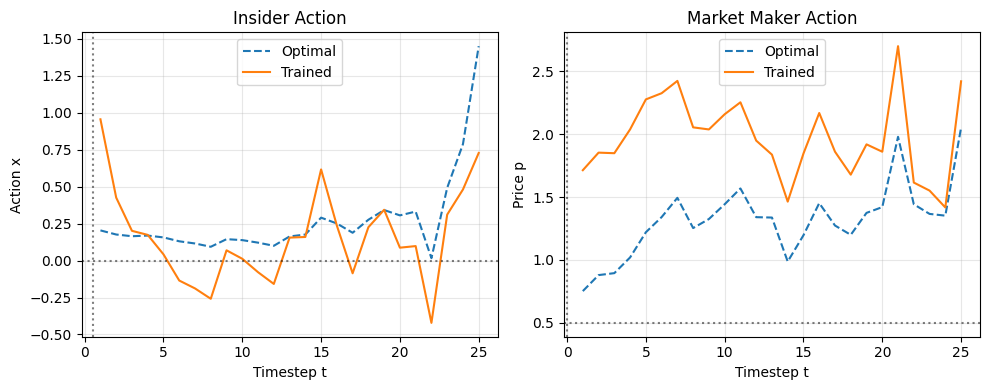

Episode: 29000


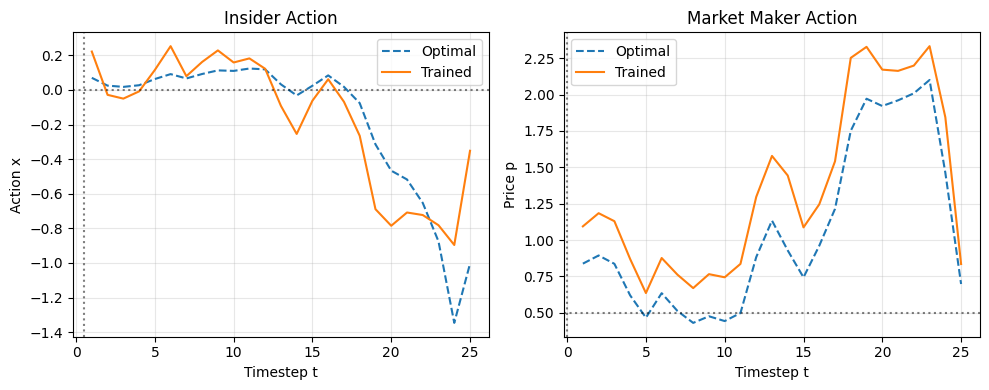

Episode: 30000


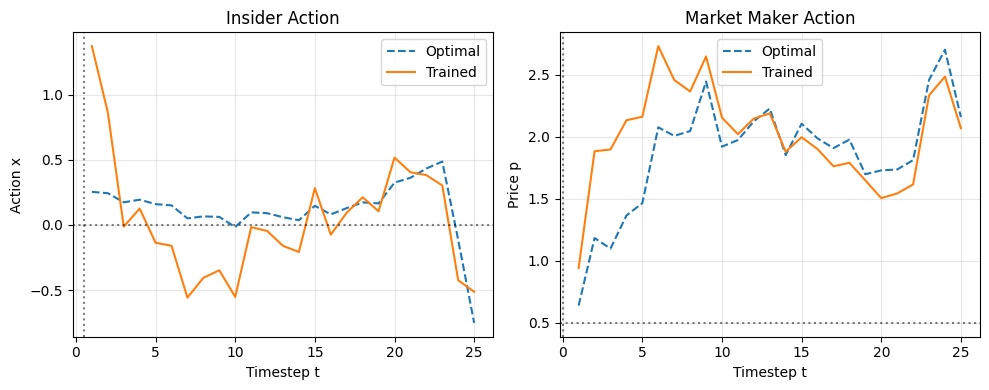

Episode: 31000


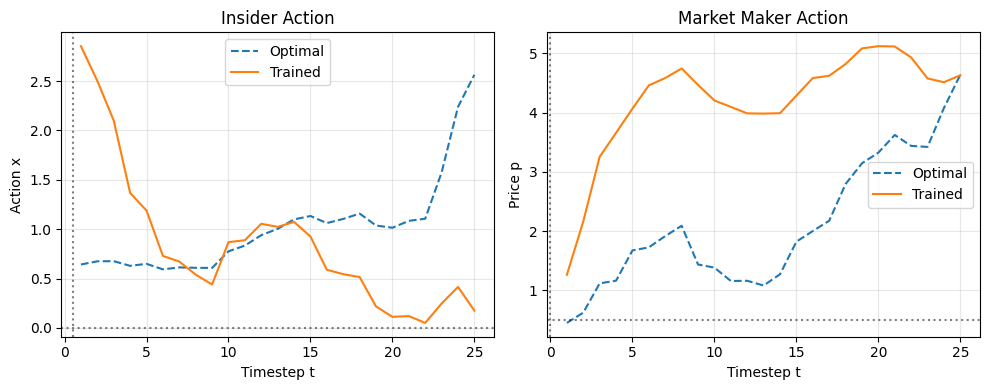

Episode: 32000


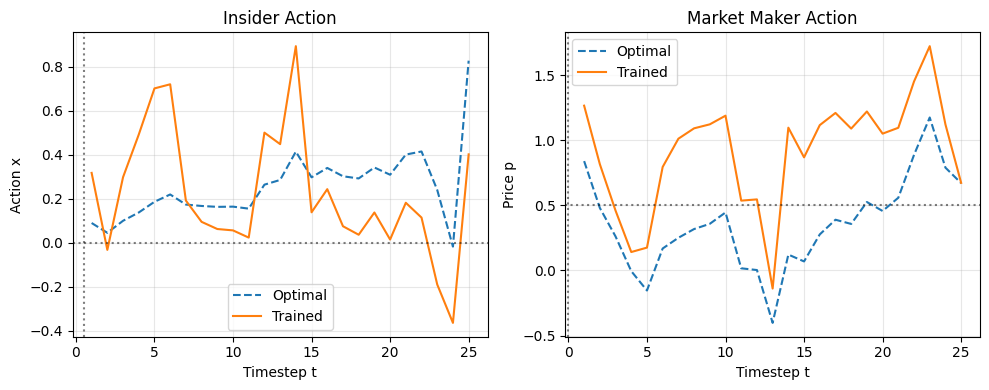

Episode: 33000


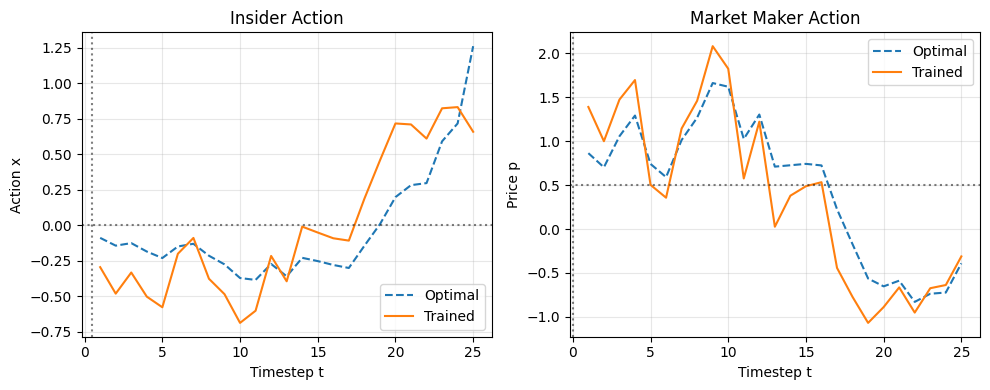

Episode: 34000


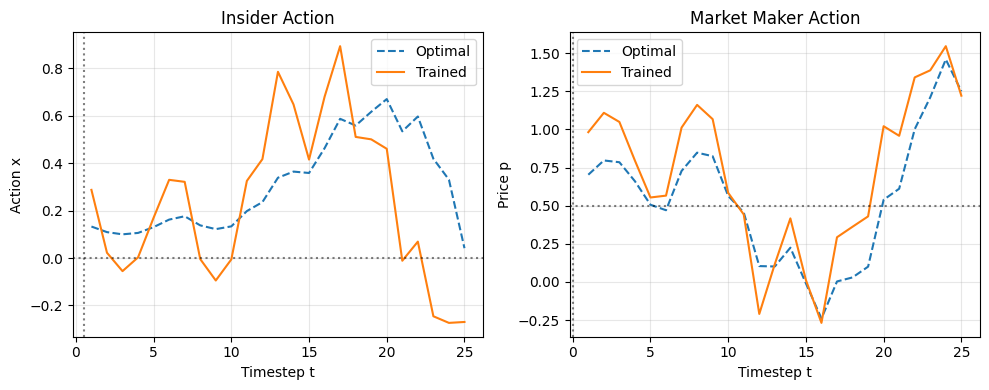

Episode: 35000


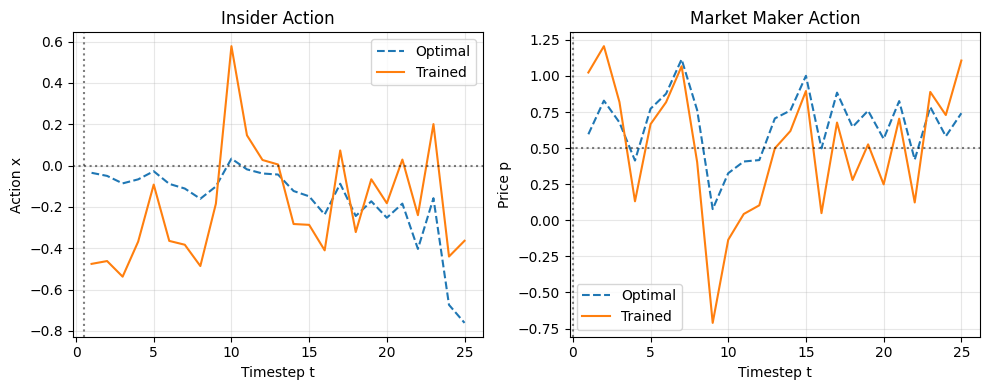

In [ ]:
num_episodes = 100_000
plot_every = 1000 # 1_000  # if leave "None", will plot 10 times over the course of training
policies, optimizers = train_both_reinforce_individual(policies, optimizers, env, num_episodes, plot_every, action_scale_factor)

### Training via: "`batch_size` rollouts, 1 update (on batched means), repeat".

*Note: unless you reinitialize policies & optimizers, this will continue training existing policies when cell is executed again*

In [ ]:
num_episodes = 15
plot_every = 1 # 1_000  # if leave "None", will plot 10 times over the course of training
policies, optimizers = train_both_reinforce_individual(policies, optimizers, env, num_episodes, plot_every, action_scale_factor)